# Silhouette score to validate detected communities by different algorithms

References
    ----------
    .. [1] `Peter J. Rousseeuw (1987). "Silhouettes: a Graphical Aid to the
       Interpretation and Validation of Cluster Analysis". Computational
       and Applied Mathematics 20: 53-65.
       <https://www.sciencedirect.com/science/article/pii/0377042787901257>`_
    .. [2] `Wikipedia entry on the Silhouette Coefficient
       <https://en.wikipedia.org/wiki/Silhouette_(clustering)>`_

In [2]:
from sklearn.metrics import silhouette_score
import geopandas as gpd
import pandas as pd
import numpy as np
import sys


UF = 'RJ'

# import the municipalities shapes from the IBGE municipalities dataset (2021)
#   -> (https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais)
mun_df = gpd.read_file("../data/%s/%s_Municipios_2021.dbf"%(UF, UF), encoding = "utf-8")
mun_df['code'] = np.array([item[:-1] for item in np.array(mun_df.CD_MUN)]).astype('int') # trim last char

# import the patient flow data
df = pd.read_csv("../data/%s/mun_sih_flow.csv"%UF)

# create the future "distance"-between-municipalities array,
#   where "distance" represent the inverse value of patient relation between two mun
#   (>> patient relation ~ << "distance")
X = pd.DataFrame(0, columns=mun_df['code'].values, index=mun_df['code'].values)
#X = np.empty([mun_df.shape[0], mun_df.shape[0]])

X.shape

(92, 92)

In [33]:
year = 1994

year_df = df[df['year']==year]
year_df['from'] = year_df['from'].map(lambda x: eval(x)['code'])
year_df['to'] = year_df['to'].map(lambda x: eval(x)['code'])

year_df.shape

<ipython-input-33-b251c611f7e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['from'] = year_df['from'].map(lambda x: eval(x)['code'])
<ipython-input-33-b251c611f7e6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['to'] = year_df['to'].map(lambda x: eval(x)['code'])


(641, 5)

In [34]:
for _, _, f, t, hosp, dist in year_df.itertuples():
    X.loc[f, t] += hosp
    X.loc[t, f] += hosp
#     if(f!=t):
#         X.loc[f, t] *= 1/dist
#         X.loc[t, f] *= 1/dist

X = 1/X

max_value = X[X!=float('inf')].max().max()
X[X==float('inf')] = 2*max_value

np.fill_diagonal(X.to_numpy(), 0)
X

330010  330015  330020  330022  330023  330025    330030    330040  \
330010  0.000000     2.0     2.0     2.0     2.0     2.0  2.000000  1.000000   
330015  2.000000     0.0     2.0     2.0     2.0     2.0  2.000000  2.000000   
330020  2.000000     2.0     0.0     2.0     2.0     2.0  2.000000  2.000000   
330022  2.000000     2.0     2.0     0.0     2.0     2.0  2.000000  2.000000   
330023  2.000000     2.0     2.0     2.0     0.0     2.0  2.000000  2.000000   
...          ...     ...     ...     ...     ...     ...       ...       ...   
330600  2.000000     2.0     1.0     2.0     2.0     2.0  2.000000  2.000000   
330610  2.000000     2.0     2.0     2.0     2.0     2.0  0.071429  0.071429   
330615  2.000000     2.0     2.0     2.0     2.0     2.0  2.000000  2.000000   
330620  2.000000     2.0     2.0     2.0     2.0     2.0  0.111111  2.000000   
330630  0.076923     2.0     2.0     2.0     2.0     2.0  0.200000  0.032258   

        330045  330050  ...  330560  330570  330575  330580  330590    330600  \
330010     2.0     2.0  ...     2.0     2.0     2.0     2.0     2.0  2.000000   
330015     2.0     2.0  ...     2.0     2.0     2.0     2.0     2.0  2.000000   
330020     2.0     2.0  ...     2.0     2.0     2.0     2.0     2.0  1.000000   
330022     2.0     2.0  ...     2.0     2.0     2.0     2.0     2.0  2.000000   
330023     2.0     2.0  ...     2.0     2.0     2.0     2.0     2.0  2.000000   
...        ...     ...  ...     ...     ...     ...     ...     ...       ...   
330600     2.0     2.0  ...     2.0     2.0     2.0     1.0     2.0  0.000000   
330610     2.0     2.0  ...     2.0     2.0     2.0     2.0     2.0  2.000000   
330615     2.0     2.0  ...     2.0     2.0     2.0     2.0     2.0  2.000000   
330620     2.0     2.0  ...     2.0     2.0     2.0     2.0     2.0  0.333333   
330630     2.0     2.0  ...     2.0     2.0     2.0     2.0     2.0  1.000000   

         330610  330615    330620    330630  
330010  2.00000     2.0  2.000000  0.076923  
330015  2.00000     2.0  2.000000  2.000000  
330020  2.00000     2.0  2.000000  2.000000  
330022  2.00000     2.0  2.000000  2.000000  
330023  2.00000     2.0  2.000000  2.000000  
...         ...     ...       ...       ...  
330600  2.00000     2.0  0.333333  1.000000  
330610  0.00000     2.0  0.024390  0.125000  
330615  2.00000     0.0  2.000000  2.000000  
330620  0.02439     2.0  0.000000  2.000000  
330630  0.12500     2.0  2.000000  0.000000  

[92 rows x 92 columns]

In [43]:
infomap_result_labels = pd.read_csv("./infomap_result_%d.csv"%year)['community']
infomap_result_labels[infomap_result_labels.isna()] = infomap_result_labels.max() + 1
i_score = silhouette_score(X.to_numpy().T, infomap_result_labels.to_numpy(), metric="precomputed")
print("Infomap score:", i_score)

Infomap score: 0.18301319277510633


In [44]:
greedy_result_labels = pd.read_csv("./greedy_result_%d.csv"%year)['community']
greedy_result_labels[greedy_result_labels.isna()] = greedy_result_labels.max() + 1
g_score = silhouette_score(X.to_numpy().T, greedy_result_labels.to_numpy(), metric="precomputed")
print("Greedy score:", g_score)

Greedy score: 0.2016514911314963


In [45]:
louvain_result_labels = pd.read_csv("./louvain_result_%d.csv"%year)['community']
louvain_result_labels[louvain_result_labels.isna()] = louvain_result_labels.max() + 1
l_score = silhouette_score(X.to_numpy().T, louvain_result_labels.to_numpy(), metric="precomputed")
print("Louvain score:",l_score)

Louvain score: 0.15626214416307038


--------------

In [14]:
from sklearn.metrics import silhouette_score
import geopandas as gpd
import pandas as pd
import numpy as np


UF = 'CE'

# import the municipalities shapes from the IBGE municipalities dataset (2021)
#   -> (https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais)
mun_df = gpd.read_file("../data/%s/%s_Municipios_2021.dbf"%(UF, UF), encoding = "utf-8")
mun_df['code'] = np.array([item[:-1] for item in np.array(mun_df.CD_MUN)]).astype('int') # trim last char

# import the patient flow data
df = pd.read_csv("../data/%s/mun_sih_flow.csv"%UF)

def get_X(year_df):
    X = pd.DataFrame(0, columns=mun_df['code'].values, index=mun_df['code'].values)
    
    for _, _, f, t, hosp, dist in year_df.itertuples():
        X.loc[f, t] += hosp
        X.loc[t, f] += hosp
    #     if(f!=t):
    #         X.loc[f, t] *= 1/dist
    #         X.loc[t, f] *= 1/dist

    X = 1/X

    max_value = X[X!=float('inf')].max().max()
    X[X==float('inf')] = 2*max_value

    np.fill_diagonal(X.to_numpy(), 0)
    return X

validate_df = pd.read_csv("../prepare/silhouette_validation.csv", index_col='year')

for year in range(1994, 2021):
    year_df = df[df['year']==year]
    year_df['from'] = year_df['from'].map(lambda x: eval(x)['code'])
    year_df['to'] = year_df['to'].map(lambda x: eval(x)['code'])

    unfixed_infomap_result_labels = pd.read_csv("./%s_infomap_unfixed_result_%d.csv"%(UF, year))['community']
    unfixed_infomap_result_labels[unfixed_infomap_result_labels.isna()] = unfixed_infomap_result_labels.max() + 1
    u_score = silhouette_score(get_X(year_df).to_numpy().T, unfixed_infomap_result_labels.to_numpy(), metric="precomputed")
    validate_df.loc[year, 'infomap unfixed'] = u_score
    
    infomap_result_labels = pd.read_csv("./%s_infomap_result_%d.csv"%(UF, year))['community']
    infomap_result_labels[infomap_result_labels.isna()] = infomap_result_labels.max() + 1
    i_score = silhouette_score(get_X(year_df).to_numpy().T, infomap_result_labels.to_numpy(), metric="precomputed")
    validate_df.loc[year, 'infomap region'] = i_score
    
    infomap_result_labels = pd.read_csv("./%s_infomap_macro_result_%d.csv"%(UF, year))['community']
    infomap_result_labels[infomap_result_labels.isna()] = infomap_result_labels.max() + 1
    m_score = silhouette_score(get_X(year_df).to_numpy().T, infomap_result_labels.to_numpy(), metric="precomputed")
    validate_df.loc[year, 'infomap macroregion'] = m_score
    
    
    
    unfixed_infomap_result_labels = pd.read_csv("./%s_infomap_unfixed_undirected_result_%d.csv"%(UF, year))['community']
    unfixed_infomap_result_labels[unfixed_infomap_result_labels.isna()] = unfixed_infomap_result_labels.max() + 1
    u_score = silhouette_score(get_X(year_df).to_numpy().T, unfixed_infomap_result_labels.to_numpy(), metric="precomputed")
    validate_df.loc[year, 'infomap undirected unfixed'] = u_score
    
    infomap_result_labels = pd.read_csv("./%s_infomap_undirected_result_%d.csv"%(UF, year))['community']
    infomap_result_labels[infomap_result_labels.isna()] = infomap_result_labels.max() + 1
    i_score = silhouette_score(get_X(year_df).to_numpy().T, infomap_result_labels.to_numpy(), metric="precomputed")
    validate_df.loc[year, 'infomap undirected region'] = i_score
    
    infomap_result_labels = pd.read_csv("./%s_infomap_macro_undirected_result_%d.csv"%(UF, year))['community']
    infomap_result_labels[infomap_result_labels.isna()] = infomap_result_labels.max() + 1
    m_score = silhouette_score(get_X(year_df).to_numpy().T, infomap_result_labels.to_numpy(), metric="precomputed")
    validate_df.loc[year, 'infomap undirected macroregion'] = m_score
    
    
    
    greedy_result_labels = pd.read_csv("./%s_greedy_result_%d.csv"%(UF, year))['community']
    greedy_result_labels[greedy_result_labels.isna()] = greedy_result_labels.max() + 1
    g_score = silhouette_score(get_X(year_df).to_numpy().T, greedy_result_labels.to_numpy(), metric="precomputed")
    validate_df.loc[year, 'greedy'] = g_score

#     louvain_result_labels = pd.read_csv("./%s_louvain_result_%d.csv"%(UF, year))['community']
#     louvain_result_labels[louvain_result_labels.isna()] = louvain_result_labels.max() + 1
#     l_score = silhouette_score(get_X(year_df).to_numpy().T, louvain_result_labels.to_numpy(), metric="precomputed")
#     validate_df.loc[year, 'louvain'] = l_score
    
    print(year)


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1994


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1995


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1996


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1997


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1998


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1999


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2000


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2001


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2002


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2003


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2004


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2005


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2006


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2007


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2008


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2009


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2010


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2011


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2012


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2013


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2014


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2015


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2016


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2017


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2018


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019


<ipython-input-14-6c9575f567f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-6c9575f567f1>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2020


In [15]:
validate_df

infomap region    greedy   louvain  infomap unfixed  \
year                                                        
1994        0.140133  0.108243  0.156262         0.069683   
1995        0.105200  0.139626 -0.026619         0.100152   
1996        0.100101  0.114904 -0.171148         0.166440   
1997        0.105977  0.113713 -0.309368         0.090322   
1998        0.083589  0.091705 -0.531974         0.127185   
1999        0.023139  0.118699 -0.591198         0.119845   
2000        0.104166  0.117827 -0.643248         0.134692   
2001        0.142152  0.132645 -0.570300         0.083436   
2002        0.084430  0.120344 -0.566568         0.080258   
2003        0.102618  0.097323 -0.561920         0.152685   
2004        0.087774  0.088352 -0.696221         0.177027   
2005        0.155091  0.090040 -0.610234         0.168923   
2006        0.075016  0.136144 -0.566073         0.157144   
2007        0.143550  0.059961 -0.639462         0.166983   
2008        0.088727  0.067062 -0.655362         0.180362   
2009        0.131849  0.107581 -0.700622         0.074711   
2010        0.168449  0.131225 -0.630890         0.190154   
2011        0.168299  0.067915 -0.636843         0.192821   
2012        0.167201  0.103092 -0.584058         0.187792   
2013        0.178053  0.088480 -0.633087         0.187127   
2014        0.057707  0.083455 -0.665356         0.168794   
2015        0.072563  0.111044 -0.678287         0.130815   
2016        0.034989  0.109332 -0.707144         0.140461   
2017        0.081548  0.112481 -0.712945         0.141364   
2018        0.074401  0.110408 -0.759342         0.165079   
2019        0.049096  0.099378 -0.739821         0.134569   
2020        0.063789  0.088374 -0.772911         0.112550   

      infomap macroregion  infomap undirected macroregion  \
year                                                        
1994             0.099818                        0.099465   
1995             0.144573                        0.131257   
1996             0.144217                        0.117347   
1997             0.099376                        0.113815   
1998             0.125970                        0.121347   
1999             0.124950                        0.097995   
2000             0.121444                        0.102678   
2001             0.102375                        0.090408   
2002             0.121526                        0.106975   
2003             0.102592                        0.088958   
2004             0.109922                        0.100151   
2005             0.111414                        0.099031   
2006             0.122212                        0.114195   
2007             0.111489                        0.119654   
2008             0.116235                        0.100385   
2009             0.108115                        0.104595   
2010             0.113657                        0.097699   
2011             0.115450                        0.101554   
2012             0.116063                        0.106558   
2013             0.098293                        0.097587   
2014             0.109918                        0.099429   
2015             0.101709                        0.099825   
2016             0.106933                        0.096885   
2017             0.103607                        0.099584   
2018             0.146100                        0.144555   
2019             0.132980                        0.109716   
2020             0.096400                        0.090362   

      infomap undirected region  infomap undirected unfixed  
year                                                         
1994                   0.144853                    0.070450  
1995                   0.145281                    0.121090  
1996                   0.054737                    0.095212  
1997                   0.090799                    0.059269  
1998                   0.095617                    0.106080  
1999                   0.008674 

In [16]:
validate_df.to_csv("../prepare/%s_silhouette_validation.csv"%UF)

-----------

In [18]:
import plotly.express as px
import pandas as pd

UF = 'CE'
validate_df = pd.read_csv("../prepare/%s_silhouette_validation.csv"%UF, index_col='year')

fig = px.line(validate_df, range_y=[-1, 1], title='%s: Comparing all methods'%UF)
fig.show()

----------------

In [153]:
import matplotlib.pyplot as plt
import numpy as np

UF = 'RJ'

validate_df = pd.read_csv("../prepare/%s_silhouette_validation.csv"%UF, index_col='year')

time = validate_df.index.values
income = validate_df['infomap'].values
expenses = validate_df['greedy'].values

# Initialize figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot lines
ax.plot(time, income, color="b")
ax.plot(time, expenses, color="red")

# Fill area when income > expenses with green
ax.fill_between(
    time, income, expenses, where=(income > expenses), 
    interpolate=True, color="b", alpha=0.25, 
    label="Infomap (maior em %d anos)"%validate_df[validate_df['infomap']>validate_df['greedy']].shape[0]
)

# Fill area when income <= expenses with red
ax.fill_between(
    time, income, expenses, where=(income <= expenses), 
    interpolate=True, color="red", alpha=0.25,
    label="Greedy (maior em %d anos)"%validate_df[validate_df['infomap']<validate_df['greedy']].shape[0]
)

ax.set_facecolor("whitesmoke")
ax.set(ylim=(-.5, .5))
ax.set_xticks(list(range(1994, 2021, 2)))
ax.set_yticks([-.5, 0, .5])
ax.xaxis.grid(color='grey', linestyle='--', linewidth=1)
ax.legend()

plt.title("%s: Avaliação dos agrupamentos do Infomap e do Greedy Modularity através do 'Silhouette Score' no estado"%UF)
# plt.show()
plt.savefig('./images/%s_infomap_greedy.png'%UF, bbox_inches='tight')

KeyError: 'infomap'

In [155]:
import matplotlib.pyplot as plt
import numpy as np

time = validate_df.index.values
income = validate_df['infomap'].values
expenses = validate_df['infomap unfixed'].values

# Initialize figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot lines
ax.plot(time, income, color="b")
ax.plot(time, expenses, color="m")

# Fill area when income > expenses with green
ax.fill_between(
    time, income, expenses, where=(income > expenses), 
    interpolate=True, color="b", alpha=0.25, 
    label="Infomap (maior em %d anos)"%validate_df[validate_df['infomap']>validate_df['infomap unfixed']].shape[0]
)

# Fill area when income <= expenses with red
ax.fill_between(
    time, income, expenses, where=(income <= expenses), 
    interpolate=True, color="m", alpha=0.25,
    label="Infomap unfixed (maior em %d anos)"%validate_df[validate_df['infomap']<validate_df['infomap unfixed']].shape[0]
)

ax.set_facecolor("whitesmoke")
ax.set(ylim=(-.5, .5))
ax.set_xticks(list(range(1994, 2021, 2)))
ax.set_yticks([-.5, 0, .5])
ax.xaxis.grid(color='grey', linestyle='--', linewidth=1)
ax.legend()

plt.title("%s: Avaliação dos agrupamentos do Infomap fixando a quantidade de agrupamentos\n e não fixando (unfixed) através do 'Silhouette Score' no estado"%UF)
# plt.show()
plt.savefig('./images/%s_infomap_fix.png'%UF, bbox_inches='tight')

KeyError: 'infomap macro'

-------------

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.56376469026194
For n_clusters = 6 The average silhouette_score is : 0.4504666294372765


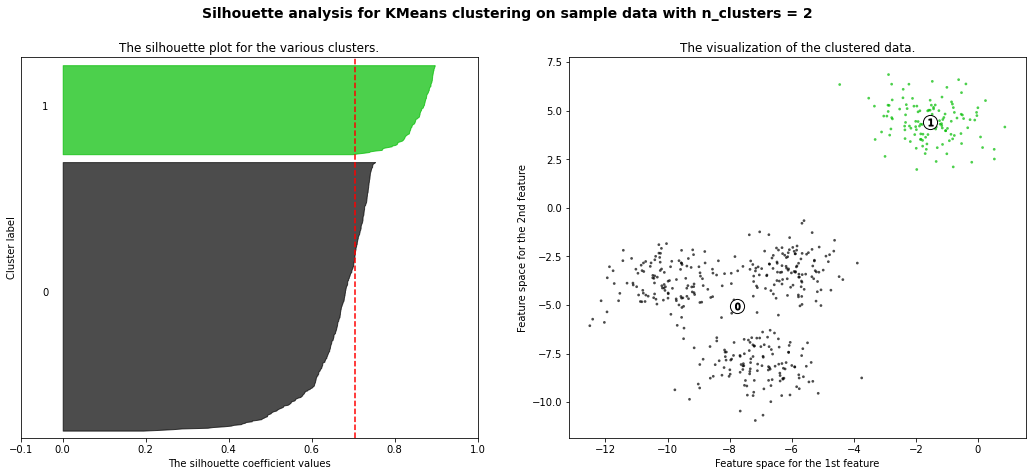

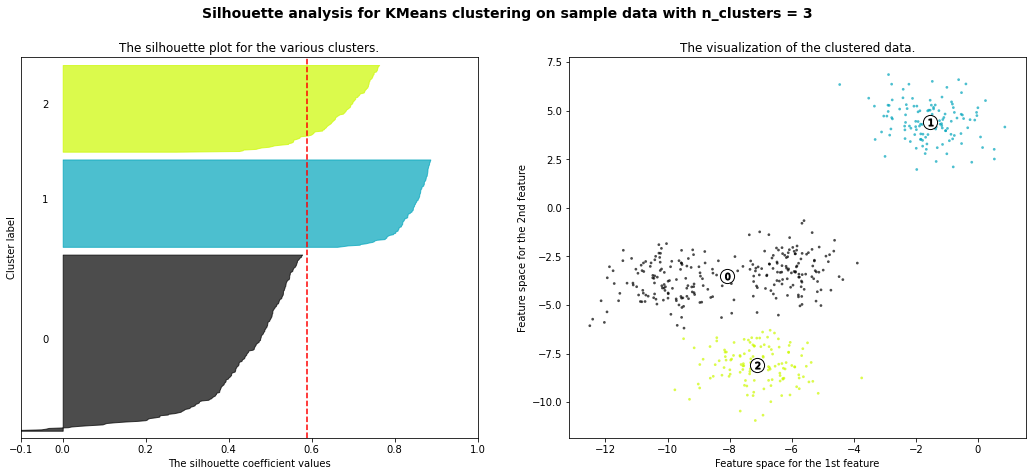

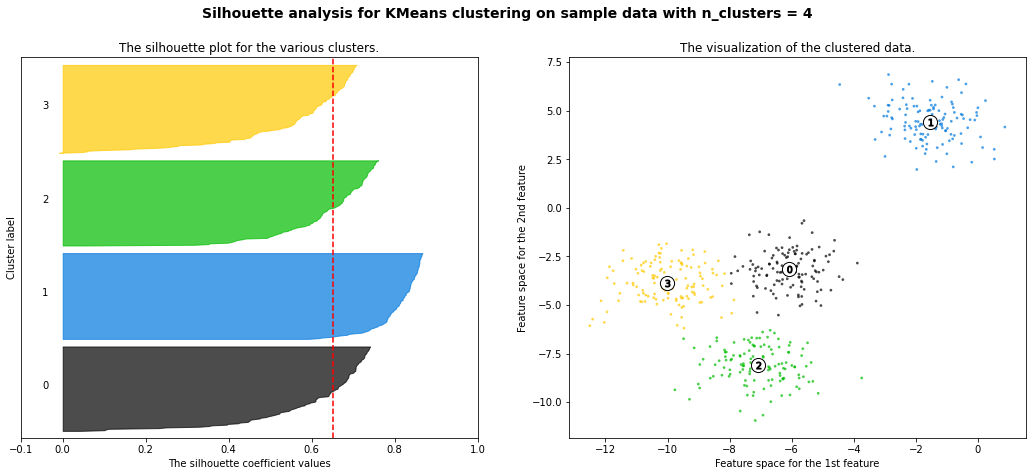

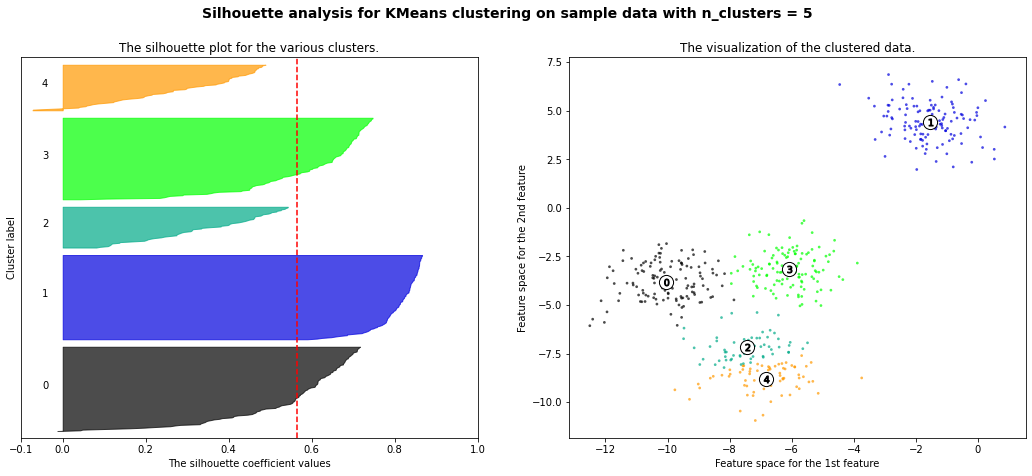

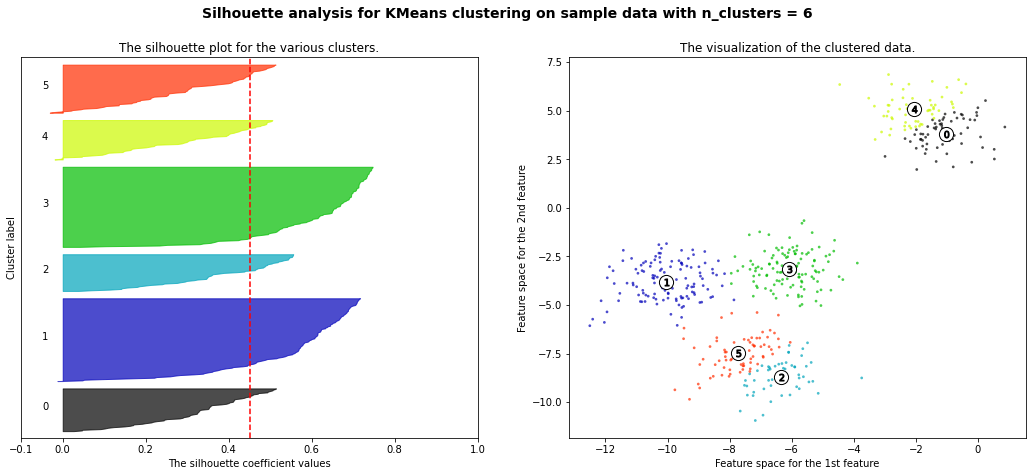

In [314]:
# RANDOM EXAMPLE

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as npcc

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()